<a href="https://colab.research.google.com/github/danialebrat/Stock_Prediction_khodro_group/blob/main/Codes/CNN_BiGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GRU, BatchNormalization, RepeatVector, TimeDistributed, Input, Conv1D, Flatten, Reshape
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Stock Prediction/Data.npy"

In [ ]:
n_past = 5
n_future = 1

In [ ]:
def load_data(data_path):
    
    path = np.load(data_path)
    
    print(np.shape(path))

    return path

In [ ]:
def split_path(path):
    
    X = []
    Y = []
    
    for i in path:
        
        X.append(i[0:n_past])
        Y.append(i[n_past:])
        
    
    return np.array(X), np.array(Y)

In [ ]:
def prepare_datasets(test_size, validation_size):
    
    # load data
    path = load_data(DATA_PATH)
    
    train, test = train_test_split(path , test_size=test_size)
        
    x_train, y_train = split_path(train)
    
    x_test, y_test = split_path(test)
    
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=validation_size)
   

    return x_train, x_validation, x_test, y_train, y_validation, y_test

In [ ]:
def plot_history(history):
    
    """ plot accuracy/loss for training/validation set as a function of the epochs"""

    plt.plot(history.history["loss"], label="train error")
    plt.plot(history.history["val_loss"], label="validation error")
    plt.ylabel("Error")
    plt.xlabel("Epoch")
    plt.legend(loc="upper right")

    plt.savefig('Accuracy eval.png', dpi=100, bbox_inches='tight')
    plt.show()

In [ ]:
def build_model(input_shape):

    # build network topology
    model = Sequential()

    model = cnn_model(model, input_shape)

    model = rnn_model(model, input_shape)

    # dense layer
    model.add(TimeDistributed(Dense(input_shape[1] , activation='LeakyReLU')))

    return model

In [ ]:
def rnn_model(model, input_shape):

        
    model.add(Bidirectional(GRU(16, name="Bidirectional_GRU_1", dropout = 0.4)))
    model.add(BatchNormalization())

    # Decoder
    model.add(RepeatVector(n = n_future))

    # GRU Layers
    model.add(Bidirectional(GRU(32, return_sequences=True, name="Bidirectional_GRU_2", dropout = 0.2)))
    model.add(BatchNormalization())

    model.add(Bidirectional(GRU(64, return_sequences=True, name="Bidirectional_GRU_3", dropout = 0.3)))
    model.add(BatchNormalization())

    model.add(Bidirectional(GRU(128, return_sequences=True, name="Bidirectional_GRU_4", dropout = 0.4)))
    model.add(BatchNormalization())

    return model



In [ ]:
def cnn_model(model, input_shape):

    #1st conv layer
    model.add(Conv1D(128, 3, activation='LeakyReLU', input_shape= input_shape, padding='same', name="Conv1D_1"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    #2nd conv layer

    model.add(Conv1D(64, 3, activation='LeakyReLU', padding='same', name="Conv1D_2"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    #3rd conv layer

    model.add(Conv1D(32, 3, activation='LeakyReLU', padding='same', name="Conv1D_3"))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    return model

(4990, 6, 1)
(4503, 5, 1)
(4503, 1, 1)
(237, 5, 1)
(237, 1, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 5, 128)            512       
                                                                 
 batch_normalization (BatchN  (None, 5, 128)           512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 5, 64)             24640     
                                                                 
 batch_normalization_1 (Batc  (None, 5, 64)            256       
 hNormalization)                                                 
                                                           

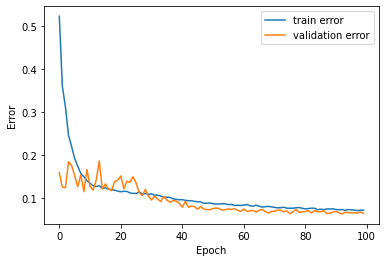

8/8 - 0s - loss: 0.0624 - root_mean_squared_error: 0.2498 - 46ms/epoch - 6ms/step

Test Accuracy :  0.24980515241622925


In [ ]:
if __name__ == "__main__":
    
    # get train, validation , test splits
    x_train, x_validation, x_test, y_train, y_validation, y_test = prepare_datasets(0.05, 0.05)
    
    print(x_train.shape)
    print(y_train.shape)
    print(x_validation.shape)
    print(y_validation.shape)


    np.save("x_test_stock_CNN", x_test)
    np.save("y_test_stock_CNN", y_test)

    # create network
    input_shape = (x_train.shape[1], x_train.shape[2])
    
    model = build_model(input_shape)

    # compile model
    optimizer = Adam(learning_rate=0.0007)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[metrics.RootMeanSquaredError()])

    checkpoint_callback = ModelCheckpoint('Stock_model_CNN_BiGRU.h5', monitor='val_root_mean_squared_error', verbose=1,
                                          save_best_only=True, mode='min')
    
    es = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=30)

    reducelr_callback = ReduceLROnPlateau(
        monitor='val_root_mean_squared_error', factor=0.7, patience=7, min_delta=0.00001,
        verbose=1
    )

    callbacks_list = [checkpoint_callback, reducelr_callback, es]

    model.summary()

    # train model
    history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=32, epochs=100,
                        callbacks=callbacks_list)

    # plot accuracy
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print("\nTest Accuracy : ", test_acc)

